In [1]:
!sudo apt install git-lfs
!git lfs clone https://github.com/pddasig/Machine-Learning-Competition-2024.git
# !pip install transformers matplotlib dlisio scikit-learn pandas lasio
!pip install dlisio lasio albumentations


Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'Machine-Learning-Competition-2024'...
remote: Enumerating objects: 8227, done.
remote: Counting objects: 100% (4121/4121), done.
remote: Compressing objects: 100% (3369/3369), done.
remote: Total 8227 (delta 14), reused 4101 (delta 3), pack-reused 4106 (from 2)
Receiving objects: 100% (8227/8227), 713.76 MiB | 41.80 MiB/s, done.
Resolving deltas: 100% (56/56), done.
https://git-lfs.github.com/spec/v1 is not a valid attribute name: .gitattributes:1
sha256:da82a15e13b7163aef0def74f6e4e6fc5d1531269562e557084403ff032e62fb is not a valid attribute name: .gitattributes:2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.0/743.0 kB 47.5 MB/s et

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import ViTForImageClassification
import cv2
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import defaultdict
import torch.optim.swa_utils as swa_utils
import lasio
from dlisio import dlis

MAIN_PATH = './Machine-Learning-Competition-2024/fracture_identification'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 224
SEEDS = [42, 123, 456]


def static2dynamic(image_data):
    """Convert static image to dynamic for better contrast"""
    q3 = np.nanquantile(image_data[image_data < 255.0], 0.03)
    q97 = np.nanquantile(image_data[image_data < 255.0], 0.97)
    image_data_dynamic = image_data.apply(lambda x: 255 * (x - q3) / (q97 - q3))
    image_data_dynamic[image_data_dynamic < 0] = 0
    image_data_dynamic[image_data_dynamic > 255] = 255
    return image_data_dynamic

def create_multi_track_image(borehole_image, well_logs, depth_range, log_names):
    """Create image with borehole image and log curves"""
    plt.ioff()  # Turn off interactive mode
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Plot borehole image without text
    ax1.imshow(borehole_image, cmap='YlOrBr_r', aspect='auto',
               extent=[0, 360, depth_range[1], depth_range[0]])
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot log curves with different colors
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    depth_idx = np.linspace(depth_range[0], depth_range[1], len(well_logs[log_names[0]]))

    for i, name in enumerate(log_names):
        data = well_logs[name]
        normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
        ax2.plot(normalized_data, depth_idx, color=colors[i])

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim(depth_range[1], depth_range[0])

    plt.subplots_adjust(wspace=0.02, hspace=0)

    # Convert plot to image array
    fig.canvas.draw()
    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    # Reshape it to a Height x Width x 4 array
    img = buf.reshape(h, w, 4)
    # Convert RGBA to RGB
    img = img[:, :, :3]

    # plt.show()
    plt.close(fig)
    plt.ion()  # Turn interactive mode back on

    return img

def generate_fracture_views(well_images, well_logs, fracture_data):
    """
    Generate fracture views using 0.15m sampling rate.
    Each view represents 1 meter window centered at different depths around the fracture.
    """
    views = []
    labels = []

    for _, row in tqdm(fracture_data.iterrows(), desc="Generating fracture views"):
        well = row['Well']
        fracture_depth = row['Depth']
        well_name = f"well_{well}"

        # Calculate sampling points around the fracture
        # Generate views with 0.15m increments in a ±0.5m range
        sampling_points = np.arange(-0.5, 0.5, 0.15)

        for offset in sampling_points:
            center_depth = fracture_depth + offset
            top_depth = center_depth - 0.5  # 0.5m above center
            bottom_depth = center_depth + 0.5  # 0.5m below center

            # Get image data
            idx_top = (np.abs(well_images[well_name].index - top_depth)).argmin()
            idx_bottom = (np.abs(well_images[well_name].index - bottom_depth)).argmin()
            image_data = well_images[well_name].iloc[idx_top:idx_bottom]

            # Get log data
            log_data = well_logs[well_name]
            log_idx_top = (np.abs(log_data.index - top_depth)).argmin()
            log_idx_bottom = (np.abs(log_data.index - bottom_depth)).argmin()

            logs_dict = {
                'GR': log_data.GR.iloc[log_idx_top:log_idx_bottom].values,
                'ILD': np.log10(log_data.ILD.iloc[log_idx_top:log_idx_bottom].values),
                'NPOR': log_data.NPOR_LIM.iloc[log_idx_top:log_idx_bottom].values,
                'RHOB': log_data.RHO.iloc[log_idx_top:log_idx_bottom].values,
                'DTC': log_data.DT.iloc[log_idx_top:log_idx_bottom].values
            }

            # Convert to dynamic image
            image_data_dynamic = static2dynamic(image_data)

            # Create multi-track view
            multi_track = create_multi_track_image(
                image_data_dynamic,
                logs_dict,
                (top_depth, bottom_depth),
                ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
            )

            views.append(multi_track)
            labels.append(1)  # Fracture present

    return views, labels

def generate_non_fracture_views(well_images, well_logs, fracture_data, num_samples_per_section=7):
    """
    Generate non-fracture views using 0.15m sampling rate.
    Each view represents 1 meter window with 0.15m increment between consecutive images.
    """
    views = []
    labels = []

    # Group fractures by well
    well_fractures = fracture_data.groupby('Well')['Depth'].apply(list).to_dict()

    for well in tqdm(well_images.keys(), desc="Generating non-fracture views"):
        if well.startswith('well_T'):
            continue

        well_letter = well.split('_')[1]
        if well_letter not in well_fractures:
            continue

        fracture_depths = sorted(well_fractures[well_letter])
        log_data = well_logs[well]

        # Look for spaces between fractures
        for i in range(len(fracture_depths) - 1):
            start_depth = fracture_depths[i] + 1.0  # 1m after current fracture
            end_depth = fracture_depths[i+1] - 1.0  # 1m before next fracture

            if end_depth - start_depth >= 2.0:  # Ensure enough space for sampling
                # Generate sampling points with 0.15m increment
                sampling_points = np.arange(start_depth, end_depth, 0.15)

                # Randomly select points if we have too many
                if len(sampling_points) > num_samples_per_section:
                    sampling_points = np.random.choice(sampling_points, num_samples_per_section, replace=False)

                for center_depth in sampling_points:
                    top_depth = center_depth - 0.5
                    bottom_depth = center_depth + 0.5

                    # Get image data
                    idx_top = (np.abs(well_images[well].index - top_depth)).argmin()
                    idx_bottom = (np.abs(well_images[well].index - bottom_depth)).argmin()
                    image_data = well_images[well].iloc[idx_top:idx_bottom]

                    # Get log data
                    log_idx_top = (np.abs(log_data.index - top_depth)).argmin()
                    log_idx_bottom = (np.abs(log_data.index - bottom_depth)).argmin()

                    logs_dict = {
                        'GR': log_data.GR.iloc[log_idx_top:log_idx_bottom].values,
                        'ILD': np.log10(log_data.ILD.iloc[log_idx_top:log_idx_bottom].values),
                        'NPOR': log_data.NPOR_LIM.iloc[log_idx_top:log_idx_bottom].values,
                        'RHOB': log_data.RHO.iloc[log_idx_top:log_idx_bottom].values,
                        'DTC': log_data.DT.iloc[log_idx_top:log_idx_bottom].values
                    }

                    image_data_dynamic = static2dynamic(image_data)

                    multi_track = create_multi_track_image(
                        image_data_dynamic,
                        logs_dict,
                        (top_depth, bottom_depth),
                        ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
                    )

                    views.append(multi_track)
                    labels.append(0)  # No fracture

    return views, labels

    if len(views) > num_samples:
        indices = np.random.choice(len(views), num_samples, replace=False)
        views = [views[i] for i in indices]
        labels = [labels[i] for i in indices]

    return views, labels

class FractureDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def eval(self):
        for model in self.models:
            model.eval()

    def predict(self, x):
        outputs = []
        with torch.no_grad():
            for model in self.models:
                output = model(x).logits
                probs = torch.softmax(output, dim=1)
                outputs.append(probs)
        return torch.mean(torch.stack(outputs), dim=0)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    """
    Training function with class balancing based on actual data distribution
    """
    best_val_f1 = 0
    best_model_state = None
    history = defaultdict(list)

    # Calculate class distribution from the training data
    all_labels = []
    for _, labels in train_loader:
        all_labels.extend(labels.cpu().numpy())

    class_counts = np.bincount(all_labels)
    total_samples = sum(class_counts)
    class_weights = torch.FloatTensor([total_samples/count for count in class_counts]).to(DEVICE)

    # Update criterion with actual class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    print(f"\nClass distribution in training data:")
    print(f"Non-fracture samples: {class_counts[0]}")
    print(f"Fracture samples: {class_counts[1]}")
    print(f"Using class weights: {class_weights.cpu().numpy()}\n")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_targets = []

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_f1 = f1_score(train_targets, train_preds, pos_label=1, average='binary')

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_f1 = f1_score(val_targets, val_preds, pos_label=1, average='binary')

        # Print detailed metrics
        print("\nTraining Metrics:")
        print(classification_report(train_targets, train_preds))
        print("\nValidation Metrics:")
        print(classification_report(val_targets, val_preds))

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}')

        # Update scheduler
        if scheduler is not None:
            scheduler.step(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print(f"New best model saved! F1: {val_f1:.4f}")

        # Save history
        history['train_loss'].append(train_loss/len(train_loader))
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss/len(val_loader))
        history['val_f1'].append(val_f1)

    return best_model_state, best_val_f1, history

def get_weighted_sampler(subset_dataset):
    """
    Create a weighted sampler based on actual class distribution from a subset
    """
    # Get labels for the subset
    if isinstance(subset_dataset, Subset):
        # Handle case when input is a Subset
        labels = [subset_dataset.dataset.labels[i] for i in subset_dataset.indices]
    else:
        # Handle case when input is the full dataset
        labels = subset_dataset.labels

    # Calculate class weights
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[label] for label in labels]

    print(f"\nClass distribution in sampled data:")
    print(f"Class 0 (non-fracture): {class_counts[0]} samples")
    print(f"Class 1 (fracture): {class_counts[1]} samples")
    print(f"Using weights - Class 0: {class_weights[0]:.4f}, Class 1: {class_weights[1]:.4f}")

    sampler = WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(labels),
        replacement=True
    )

    return sampler, class_counts

def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


Using device: cuda
Loading well data...


Loading training wells: 100%|██████████| 8/8 [00:13<00:00,  1.67s/it]


Generating fracture views...


Generating fracture views: 43it [00:39,  1.08it/s]/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
Generating fracture views: 44it [00:40,  1.10it/s]/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: i

Generating non-fracture views...


Generating non-fracture views:  38%|███▊      | 3/8 [05:59<08:30, 102.12s/it]/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountere


Displaying example images...


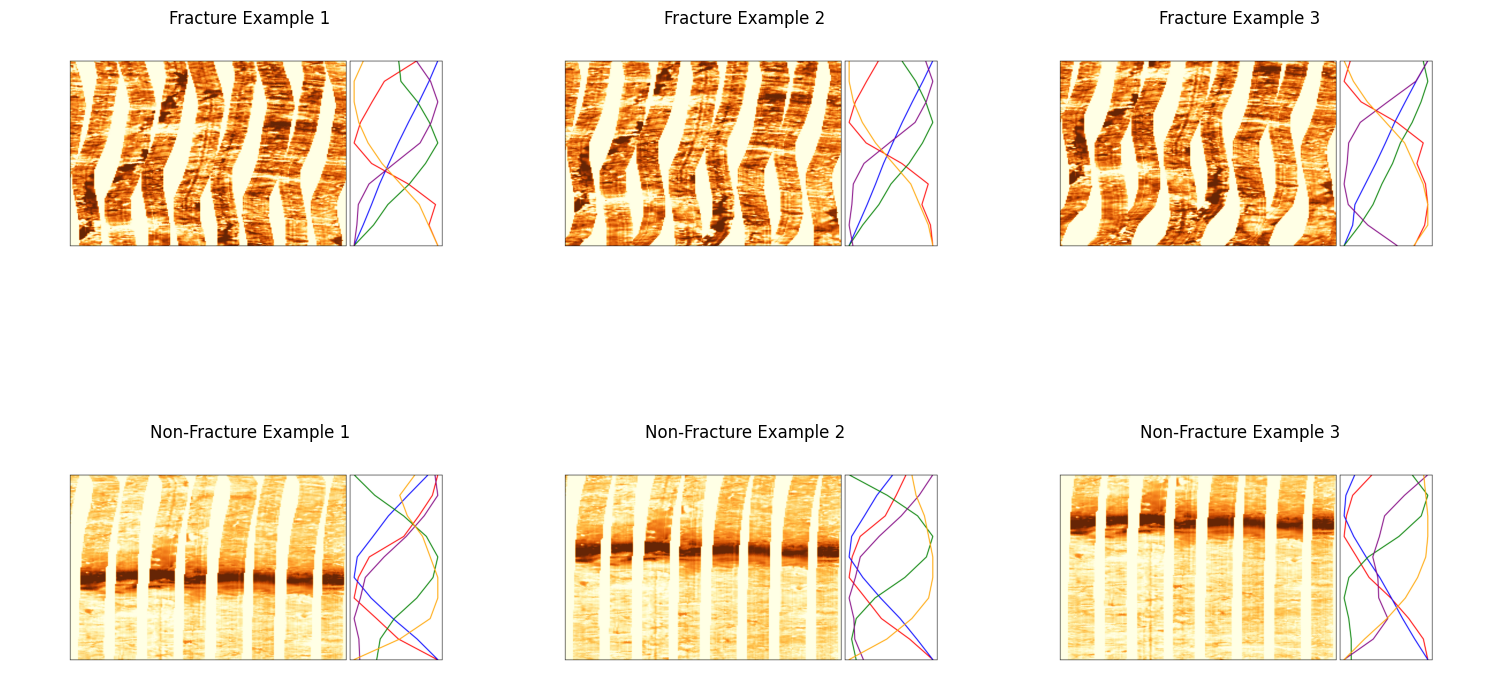


Total dataset size: 8076
Number of fracture images: 805
Number of non-fracture images: 7271


In [5]:
print(f"Using device: {DEVICE}")

# Load well data
print("Loading well data...")
well_images = {}
well_logs = {}

# Training wells
wells = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
for well in tqdm(wells, desc="Loading training wells"):
    # Load image data
    well_dlis, *_ = dlis.load(f"{MAIN_PATH}/frac_data/training_data/Well_{well}_Image.dlis")
    curves = well_dlis.object('FRAME','IMAGE').curves()
    well_name = f"well_{well}"
    well_images[well_name] = pd.DataFrame(
        curves[str(well_dlis.channels[1])[8:-1]],
        index=curves[str(well_dlis.channels[0])[8:-1]]
    ).mul(255.0/np.max(curves[str(well_dlis.channels[1])[8:-1]]))

    # Load log data
    well_logs[well_name] = lasio.read(
        f'{MAIN_PATH}/frac_data/training_data/{well}_Logs.las',
        engine='normal'
    ).df()

# Load fracture data
fracture_data = pd.read_csv(f"{MAIN_PATH}/frac_data/Fracture_data.csv")

# Generate views with logs
print("Generating fracture views...")
fracture_views, fracture_labels = generate_fracture_views(well_images, well_logs, fracture_data)

print("Generating non-fracture views...")
non_fracture_views, non_fracture_labels = generate_non_fracture_views(
    well_images, well_logs, fracture_data, len(fracture_views)
)

# Display example images
print("\nDisplaying example images...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Show 3 fracture examples
for i in range(3):
    axes[0, i].imshow(fracture_views[i])
    axes[0, i].set_title(f'Fracture Example {i+1}')
    axes[0, i].axis('off')

# Show 3 non-fracture examples
for i in range(3):
    axes[1, i].imshow(non_fracture_views[i])
    axes[1, i].set_title(f'Non-Fracture Example {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"{MAIN_PATH}/example_views.png")
plt.show()
plt.close()

# Combine datasets
all_views = fracture_views + non_fracture_views
all_labels = fracture_labels + non_fracture_labels

print(f"\nTotal dataset size: {len(all_views)}")
print(f"Number of fracture images: {sum(all_labels)}")
print(f"Number of non-fracture images: {len(all_labels) - sum(all_labels)}")

# Create datasets
train_transform = get_transforms(train=True)
val_transform = get_transforms(train=False)

dataset = FractureDataset(all_views, all_labels, transform=train_transform)

In [6]:


# Train ensemble models
models = []
histories = []

for seed in SEEDS:
    print(f"\nTraining model with seed {seed}")
    set_seed(seed)

    # Split data while preserving class distribution
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )

    # Create weighted sampler for training set
    train_sampler, train_class_counts = get_weighted_sampler(train_dataset)

    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        sampler=train_sampler
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False
    )
    # train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=2,
        ignore_mismatched_sizes=True
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0]).to(DEVICE))
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=2, factor=0.5
    )

    # Train model
    best_state, val_f1, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        num_epochs=15
    )

    if best_state is not None:
        model.load_state_dict(best_state)
        models.append(model)
        histories.append(history)
        print(f"Model with seed {seed} achieved validation F1: {val_f1:.4f}")

# Create ensemble model
ensemble = EnsembleModel(models)

# Plot training histories
plt.figure(figsize=(15, 5))
plt.subplot(121)
for i, history in enumerate(histories):
    plt.plot(history['train_f1'], label=f'Train F1 (seed {SEEDS[i]})')
    plt.plot(history['val_f1'], label=f'Val F1 (seed {SEEDS[i]})')
plt.title('F1 Score History')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.subplot(122)
for i, history in enumerate(histories):
    plt.plot(history['train_loss'], label=f'Train Loss (seed {SEEDS[i]})')
    plt.plot(history['val_loss'], label=f'Val Loss (seed {SEEDS[i]})')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{MAIN_PATH}/training_history.png")
plt.close()

# Save ensemble model states
model_states = [model.state_dict() for model in models]
torch.save({
    'model_states': model_states,
    'seeds': SEEDS,
}, f"{MAIN_PATH}/ensemble_model.pth")

print("\nTraining completed! Saved model states and training history plots.")

# Process test wells
test_views = {}
for well in ['T1', 'T2']:
    print(f"\nProcessing test well {well}...")
    well_name = f"well_{well}"

    # Load test well data
    well_dlis, *_ = dlis.load(f"{MAIN_PATH}/frac_data/test_data/Well_{well}_Image.dlis")
    curves = well_dlis.object('FRAME','IMAGE').curves()
    well_images[well_name] = pd.DataFrame(
        curves[str(well_dlis.channels[1])[8:-1]],
        index=curves[str(well_dlis.channels[0])[8:-1]]
    ).mul(255.0/np.max(curves[str(well_dlis.channels[1])[8:-1]]))

    well_logs[well_name] = lasio.read(
        f'{MAIN_PATH}/frac_data/test_data/{well}_Logs.las',
        engine='normal'
    ).df()

    # Generate sliding window views
    test_views[well] = []
    depths = well_images[well_name].index

    for i in tqdm(range(0, len(depths)-1000, 500), desc=f"Generating views for {well}"):
        center_depth = depths[i] + 1.0
        top_depth = center_depth - 1.0
        bottom_depth = center_depth + 1.0

        image_data = well_images[well_name].iloc[i:i+1000]
        image_data_dynamic = static2dynamic(image_data)

        # Create multi-track view
        logs_dict = {
            'GR': well_logs[well_name].GR,
            'ILD': np.log10(well_logs[well_name].ILD),
            'NPOR': well_logs[well_name].NPOR_LIM,
            'RHOB': well_logs[well_name].RHO,
            'DTC': well_logs[well_name].DT
        }

        multi_track = create_multi_track_image(
            image_data_dynamic,
            logs_dict,
            (top_depth, bottom_depth),
            ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
        )

        test_views[well].append((multi_track, center_depth))

# Make predictions
transform = get_transforms(train=False)
ensemble.eval()



Training model with seed 42

Class distribution in sampled data:
Class 0 (non-fracture): 5807 samples
Class 1 (fracture): 654 samples
Using weights - Class 0: 0.0002, Class 1: 0.0015


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class distribution in training data:
Non-fracture samples: 3219
Fracture samples: 3242
Using class weights: [2.0071452 1.9929056]


Epoch 1/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3162
           1       0.88      0.88      0.88      3299

    accuracy                           0.88      6461
   macro avg       0.88      0.88      0.88      6461
weighted avg       0.88      0.88      0.88      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1464
           1       0.93      0.68      0.79       151

    accuracy                           0.97      1615
   macro avg       0.95      0.84      0.88      1615
weighted avg       0.96      0.97      0.96      1615


Epoch 1 Summary:
Train Loss: 0.2891, Train F1: 0.8779
Val Loss: 0.1011, Val F1: 0.7863
New best model saved! F1: 0.7863

Epoch 2/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3276
           1       0.98      0.98      0.98      3185

    accuracy                           0.98      6461
   macro avg       0.98      0.98      0.98      6461
weighted avg       0.98      0.98      0.98      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1464
           1       0.71      0.92      0.80       151

    accuracy                           0.96      1615
   macro avg       0.85      0.94      0.89      1615
weighted avg       0.97      0.96      0.96      1615


Epoch 2 Summary:
Train Loss: 0.0607, Train F1: 0.9813
Val Loss: 0.1213, Val F1: 0.8012
New best model saved! F1: 0.8012

Epoch 3/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3277
           1       0.98      0.99      0.99      3184

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1464
           1       0.88      0.84      0.86       151

    accuracy                           0.97      1615
   macro avg       0.93      0.91      0.92      1615
weighted avg       0.97      0.97      0.97      1615


Epoch 3 Summary:
Train Loss: 0.0444, Train F1: 0.9853
Val Loss: 0.0645, Val F1: 0.8610
New best model saved! F1: 0.8610

Epoch 4/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3196
           1       0.99      0.99      0.99      3265

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1464
           1       0.87      0.91      0.89       151

    accuracy                           0.98      1615
   macro avg       0.93      0.95      0.94      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 4 Summary:
Train Loss: 0.0247, Train F1: 0.9927
Val Loss: 0.0574, Val F1: 0.8932
New best model saved! F1: 0.8932

Epoch 5/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.78it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3314
           1       0.99      0.99      0.99      3147

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1464
           1       0.98      0.78      0.87       151

    accuracy                           0.98      1615
   macro avg       0.98      0.89      0.93      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 5 Summary:
Train Loss: 0.0168, Train F1: 0.9940
Val Loss: 0.0918, Val F1: 0.8708

Epoch 6/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3235
           1       1.00      1.00      1.00      3226

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.97      0.92      0.94       151

    accuracy                           0.99      1615
   macro avg       0.98      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 6 Summary:
Train Loss: 0.0124, Train F1: 0.9964
Val Loss: 0.0369, Val F1: 0.9424
New best model saved! F1: 0.9424

Epoch 7/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3225
           1       1.00      1.00      1.00      3236

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1464
           1       0.90      0.86      0.88       151

    accuracy                           0.98      1615
   macro avg       0.94      0.93      0.93      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 7 Summary:
Train Loss: 0.0125, Train F1: 0.9963
Val Loss: 0.0651, Val F1: 0.8814

Epoch 8/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.77it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3333
           1       0.99      0.99      0.99      3128

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1464
           1       0.93      0.95      0.94       151

    accuracy                           0.99      1615
   macro avg       0.96      0.97      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 8 Summary:
Train Loss: 0.0246, Train F1: 0.9925
Val Loss: 0.0468, Val F1: 0.9408

Epoch 9/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3241
           1       1.00      1.00      1.00      3220

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1464
           1       0.88      0.92      0.90       151

    accuracy                           0.98      1615
   macro avg       0.94      0.95      0.94      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 9 Summary:
Train Loss: 0.0091, Train F1: 0.9978
Val Loss: 0.0704, Val F1: 0.8997

Epoch 10/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.77it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3224
           1       1.00      1.00      1.00      3237

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.96      0.90      0.93       151

    accuracy                           0.99      1615
   macro avg       0.98      0.95      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 10 Summary:
Train Loss: 0.0063, Train F1: 0.9985
Val Loss: 0.0449, Val F1: 0.9315

Epoch 11/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3215
           1       1.00      1.00      1.00      3246

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1464
           1       0.98      0.93      0.95       151

    accuracy                           0.99      1615
   macro avg       0.99      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 11 Summary:
Train Loss: 0.0012, Train F1: 0.9997
Val Loss: 0.0324, Val F1: 0.9524
New best model saved! F1: 0.9524

Epoch 12/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3269
           1       1.00      1.00      1.00      3192

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.99      0.91      0.95       151

    accuracy                           0.99      1615
   macro avg       0.99      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 12 Summary:
Train Loss: 0.0003, Train F1: 1.0000
Val Loss: 0.0344, Val F1: 0.9485

Epoch 13/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3182
           1       1.00      1.00      1.00      3279

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.98      0.92      0.95       151

    accuracy                           0.99      1615
   macro avg       0.99      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 13 Summary:
Train Loss: 0.0005, Train F1: 0.9998
Val Loss: 0.0363, Val F1: 0.9488

Epoch 14/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3212
           1       1.00      1.00      1.00      3249

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.98      0.91      0.95       151

    accuracy                           0.99      1615
   macro avg       0.98      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 14 Summary:
Train Loss: 0.0003, Train F1: 1.0000
Val Loss: 0.0400, Val F1: 0.9452

Epoch 15/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3286
           1       1.00      1.00      1.00      3175

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1464
           1       0.98      0.92      0.95       151

    accuracy                           0.99      1615
   macro avg       0.99      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 15 Summary:
Train Loss: 0.0001, Train F1: 1.0000
Val Loss: 0.0414, Val F1: 0.9488
Model with seed 42 achieved validation F1: 0.9524

Training model with seed 123

Class distribution in sampled data:
Class 0 (non-fracture): 5806 samples
Class 1 (fracture): 655 samples
Using weights - Class 0: 0.0002

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class distribution in training data:
Non-fracture samples: 3233
Fracture samples: 3228
Using class weights: [1.9984535 2.001549 ]


Epoch 1/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3201
           1       0.88      0.88      0.88      3260

    accuracy                           0.88      6461
   macro avg       0.88      0.88      0.88      6461
weighted avg       0.88      0.88      0.88      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1465
           1       0.67      0.90      0.77       150

    accuracy                           0.95      1615
   macro avg       0.83      0.93      0.87      1615
weighted avg       0.96      0.95      0.95      1615


Epoch 1 Summary:
Train Loss: 0.2843, Train F1: 0.8799
Val Loss: 0.1286, Val F1: 0.7670
New best model saved! F1: 0.7670

Epoch 2/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3225
           1       0.97      0.98      0.97      3236

    accuracy                           0.97      6461
   macro avg       0.97      0.97      0.97      6461
weighted avg       0.97      0.97      0.97      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1465
           1       0.85      0.81      0.83       150

    accuracy                           0.97      1615
   macro avg       0.92      0.90      0.91      1615
weighted avg       0.97      0.97      0.97      1615


Epoch 2 Summary:
Train Loss: 0.0764, Train F1: 0.9735
Val Loss: 0.0784, Val F1: 0.8288
New best model saved! F1: 0.8288

Epoch 3/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.72it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3255
           1       0.99      0.99      0.99      3206

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1465
           1       0.86      0.94      0.90       150

    accuracy                           0.98      1615
   macro avg       0.93      0.96      0.94      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 3 Summary:
Train Loss: 0.0326, Train F1: 0.9897
Val Loss: 0.0688, Val F1: 0.8981
New best model saved! F1: 0.8981

Epoch 4/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3307
           1       0.99      0.99      0.99      3154

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1465
           1       0.68      0.99      0.80       150

    accuracy                           0.95      1615
   macro avg       0.84      0.97      0.89      1615
weighted avg       0.97      0.95      0.96      1615


Epoch 4 Summary:
Train Loss: 0.0234, Train F1: 0.9921
Val Loss: 0.1328, Val F1: 0.8022

Epoch 5/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3279
           1       0.99      0.99      0.99      3182

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1465
           1       0.92      0.89      0.90       150

    accuracy                           0.98      1615
   macro avg       0.96      0.94      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 5 Summary:
Train Loss: 0.0256, Train F1: 0.9919
Val Loss: 0.0571, Val F1: 0.9048
New best model saved! F1: 0.9048

Epoch 6/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.69it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3300
           1       0.99      0.99      0.99      3161

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1465
           1       0.89      0.89      0.89       150

    accuracy                           0.98      1615
   macro avg       0.94      0.94      0.94      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 6 Summary:
Train Loss: 0.0191, Train F1: 0.9930
Val Loss: 0.0661, Val F1: 0.8867

Epoch 7/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3195
           1       1.00      1.00      1.00      3266

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1465
           1       0.95      0.87      0.91       150

    accuracy                           0.98      1615
   macro avg       0.97      0.93      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 7 Summary:
Train Loss: 0.0024, Train F1: 0.9994
Val Loss: 0.0526, Val F1: 0.9059
New best model saved! F1: 0.9059

Epoch 8/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3283
           1       0.99      0.99      0.99      3178

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1465
           1       0.53      0.95      0.68       150

    accuracy                           0.92      1615
   macro avg       0.76      0.93      0.82      1615
weighted avg       0.95      0.92      0.93      1615


Epoch 8 Summary:
Train Loss: 0.0219, Train F1: 0.9928
Val Loss: 0.2332, Val F1: 0.6794

Epoch 9/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.79it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3172
           1       1.00      1.00      1.00      3289

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1465
           1       0.94      0.91      0.92       150

    accuracy                           0.99      1615
   macro avg       0.96      0.95      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 9 Summary:
Train Loss: 0.0117, Train F1: 0.9967
Val Loss: 0.0512, Val F1: 0.9220
New best model saved! F1: 0.9220

Epoch 10/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.78it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3150
           1       1.00      1.00      1.00      3311

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1465
           1       0.76      0.91      0.83       150

    accuracy                           0.96      1615
   macro avg       0.87      0.94      0.90      1615
weighted avg       0.97      0.96      0.97      1615


Epoch 10 Summary:
Train Loss: 0.0073, Train F1: 0.9983
Val Loss: 0.1097, Val F1: 0.8278

Epoch 11/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3204
           1       0.99      0.99      0.99      3257

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1465
           1       0.97      0.86      0.91       150

    accuracy                           0.98      1615
   macro avg       0.98      0.93      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 11 Summary:
Train Loss: 0.0206, Train F1: 0.9931
Val Loss: 0.0580, Val F1: 0.9117

Epoch 12/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3213
           1       0.99      1.00      1.00      3248

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1465
           1       0.84      0.88      0.86       150

    accuracy                           0.97      1615
   macro avg       0.91      0.93      0.92      1615
weighted avg       0.97      0.97      0.97      1615


Epoch 12 Summary:
Train Loss: 0.0142, Train F1: 0.9951
Val Loss: 0.0925, Val F1: 0.8599

Epoch 13/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3191
           1       1.00      1.00      1.00      3270

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1465
           1       0.96      0.87      0.91       150

    accuracy                           0.98      1615
   macro avg       0.97      0.93      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 13 Summary:
Train Loss: 0.0054, Train F1: 0.9989
Val Loss: 0.0503, Val F1: 0.9123

Epoch 14/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.71it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3190
           1       1.00      1.00      1.00      3271

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1465
           1       0.96      0.89      0.92       150

    accuracy                           0.99      1615
   macro avg       0.97      0.94      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 14 Summary:
Train Loss: 0.0005, Train F1: 1.0000
Val Loss: 0.0470, Val F1: 0.9204

Epoch 15/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.72it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3194
           1       1.00      1.00      1.00      3267

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1465
           1       0.96      0.89      0.92       150

    accuracy                           0.99      1615
   macro avg       0.97      0.94      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 15 Summary:
Train Loss: 0.0003, Train F1: 1.0000
Val Loss: 0.0464, Val F1: 0.9241
New best model saved! F1: 0.9241
Model with seed 123 achieved validation F1: 0.9241

Training model with seed 456

Class distribution in sampled data:
Class 0 (non-fracture): 5799 samples
Class 1 (fracture): 662 sampl

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class distribution in training data:
Non-fracture samples: 3250
Fracture samples: 3211
Using class weights: [1.988     2.0121458]


Epoch 1/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3185
           1       0.87      0.87      0.87      3276

    accuracy                           0.87      6461
   macro avg       0.87      0.87      0.87      6461
weighted avg       0.87      0.87      0.87      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1472
           1       0.83      0.74      0.79       143

    accuracy                           0.96      1615
   macro avg       0.90      0.86      0.88      1615
weighted avg       0.96      0.96      0.96      1615


Epoch 1 Summary:
Train Loss: 0.2897, Train F1: 0.8744
Val Loss: 0.1002, Val F1: 0.7852
New best model saved! F1: 0.7852

Epoch 2/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3277
           1       0.97      0.98      0.97      3184

    accuracy                           0.97      6461
   macro avg       0.97      0.97      0.97      6461
weighted avg       0.97      0.97      0.97      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.87      0.85      0.86       143

    accuracy                           0.98      1615
   macro avg       0.93      0.92      0.92      1615
weighted avg       0.97      0.98      0.98      1615


Epoch 2 Summary:
Train Loss: 0.0804, Train F1: 0.9735
Val Loss: 0.0729, Val F1: 0.8582
New best model saved! F1: 0.8582

Epoch 3/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3189
           1       0.99      0.99      0.99      3272

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.89      0.87      0.88       143

    accuracy                           0.98      1615
   macro avg       0.94      0.93      0.93      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 3 Summary:
Train Loss: 0.0248, Train F1: 0.9931
Val Loss: 0.0732, Val F1: 0.8803
New best model saved! F1: 0.8803

Epoch 4/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3202
           1       0.99      1.00      1.00      3259

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.92      0.90      0.91       143

    accuracy                           0.98      1615
   macro avg       0.96      0.94      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 4 Summary:
Train Loss: 0.0142, Train F1: 0.9959
Val Loss: 0.0577, Val F1: 0.9078
New best model saved! F1: 0.9078

Epoch 5/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3259
           1       1.00      1.00      1.00      3202

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1472
           1       0.91      0.81      0.86       143

    accuracy                           0.98      1615
   macro avg       0.94      0.90      0.92      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 5 Summary:
Train Loss: 0.0116, Train F1: 0.9964
Val Loss: 0.0980, Val F1: 0.8561

Epoch 6/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3187
           1       0.99      0.99      0.99      3274

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.96      0.92      0.94       143

    accuracy                           0.99      1615
   macro avg       0.98      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 6 Summary:
Train Loss: 0.0352, Train F1: 0.9882
Val Loss: 0.0438, Val F1: 0.9429
New best model saved! F1: 0.9429

Epoch 7/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3255
           1       0.99      0.99      0.99      3206

    accuracy                           0.99      6461
   macro avg       0.99      0.99      0.99      6461
weighted avg       0.99      0.99      0.99      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.96      0.90      0.92       143

    accuracy                           0.99      1615
   macro avg       0.97      0.95      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 7 Summary:
Train Loss: 0.0207, Train F1: 0.9930
Val Loss: 0.0518, Val F1: 0.9242

Epoch 8/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3275
           1       1.00      1.00      1.00      3186

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.90      0.85      0.87       143

    accuracy                           0.98      1615
   macro avg       0.94      0.92      0.93      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 8 Summary:
Train Loss: 0.0130, Train F1: 0.9962
Val Loss: 0.0732, Val F1: 0.8736

Epoch 9/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.72it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3178
           1       1.00      1.00      1.00      3283

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.92      0.90      0.91       143

    accuracy                           0.98      1615
   macro avg       0.96      0.94      0.95      1615
weighted avg       0.98      0.98      0.98      1615


Epoch 9 Summary:
Train Loss: 0.0151, Train F1: 0.9957
Val Loss: 0.0515, Val F1: 0.9078

Epoch 10/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.72it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3226
           1       1.00      1.00      1.00      3235

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.96      0.91      0.94       143

    accuracy                           0.99      1615
   macro avg       0.98      0.95      0.96      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 10 Summary:
Train Loss: 0.0013, Train F1: 1.0000
Val Loss: 0.0498, Val F1: 0.9353

Epoch 11/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.73it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3278
           1       1.00      1.00      1.00      3183

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1472
           1       0.94      0.93      0.94       143

    accuracy                           0.99      1615
   macro avg       0.97      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 11 Summary:
Train Loss: 0.0024, Train F1: 0.9991
Val Loss: 0.0473, Val F1: 0.9366

Epoch 12/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3278
           1       1.00      1.00      1.00      3183

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.97      0.92      0.94       143

    accuracy                           0.99      1615
   macro avg       0.98      0.96      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 12 Summary:
Train Loss: 0.0005, Train F1: 1.0000
Val Loss: 0.0431, Val F1: 0.9424

Epoch 13/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3204
           1       1.00      1.00      1.00      3257

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.98      0.91      0.95       143

    accuracy                           0.99      1615
   macro avg       0.99      0.95      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 13 Summary:
Train Loss: 0.0003, Train F1: 1.0000
Val Loss: 0.0434, Val F1: 0.9455
New best model saved! F1: 0.9455

Epoch 14/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3180
           1       1.00      1.00      1.00      3281

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.97      0.91      0.94       143

    accuracy                           0.99      1615
   macro avg       0.98      0.95      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 14 Summary:
Train Loss: 0.0002, Train F1: 1.0000
Val Loss: 0.0431, Val F1: 0.9386

Epoch 15/15


Validation: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]



Training Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3274
           1       1.00      1.00      1.00      3187

    accuracy                           1.00      6461
   macro avg       1.00      1.00      1.00      6461
weighted avg       1.00      1.00      1.00      6461


Validation Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1472
           1       0.98      0.91      0.94       143

    accuracy                           0.99      1615
   macro avg       0.98      0.95      0.97      1615
weighted avg       0.99      0.99      0.99      1615


Epoch 15 Summary:
Train Loss: 0.0002, Train F1: 1.0000
Val Loss: 0.0436, Val F1: 0.9420
Model with seed 456 achieved validation F1: 0.9455

Training completed! Saved model states and training history plots.

Processing test well T1...


Generating views for T1: 100%|██████████| 363/363 [00:55<00:00,  6.50it/s]



Processing test well T2...


Generating views for T2: 100%|██████████| 422/422 [01:03<00:00,  6.60it/s]



Making predictions for well T1...


100%|██████████| 363/363 [00:15<00:00, 24.10it/s]



Making predictions for well T2...


100%|██████████| 422/422 [00:17<00:00, 24.08it/s]


Submission file created!


In [10]:
predictions = {well: [] for well in ['T1', 'T2']}

for well in ['T1', 'T2']:
    print(f"\nMaking predictions for well {well}...")
    for image, depth in tqdm(test_views[well]):
        image = transform(image=image)['image'].unsqueeze(0).to(DEVICE)
        probs = ensemble.predict(image)
        prob = probs[0][1].item()

        if prob > 0.5:  # Confidence threshold
            predictions[well].append((depth, prob))

# Create submission file
submission_data = []
for well in ['T1', 'T2']:
    well_preds = sorted(predictions[well], key=lambda x: x[1], reverse=True)[:15]
    for depth, _ in well_preds:
        submission_data.append({'Well': well, 'Depth': depth})

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv(f"{MAIN_PATH}/submissions/submission.csv", index=False)
print("\nSubmission file created!")


Making predictions for well T1...


100%|██████████| 363/363 [00:14<00:00, 24.22it/s]



Making predictions for well T2...


100%|██████████| 422/422 [00:17<00:00, 24.17it/s]


Submission file created!


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_submission_fractures(submission_csv_path, well_images, well_logs, save_plots=True, output_dir="./submission_plots/"):
    """
    Reads submission.csv and generates multi-track images for each detected fracture in the T1 and T2 wells.
    It then plots and optionally saves each plot to disk.
    
    Parameters:
        submission_csv_path (str): Path to the CSV file containing fracture detections.
        well_images (dict): Dictionary with keys (e.g., 'well_T1', 'well_T2') containing the image DataFrames.
        well_logs (dict): Dictionary with keys corresponding to the wells containing the well log DataFrames.
        save_plots (bool): If True, saves the generated plots to disk.
        output_dir (str): Directory where the plots will be saved if save_plots is True.
    """
    # Load submission data
    submission_df = pd.read_csv(submission_csv_path)
    
    # Create output directory if saving plots is enabled
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    # Loop through each prediction in the submission file
    for idx, row in submission_df.iterrows():
        well = row['Well']
        depth = row['Depth']
        well_name = f"well_{well}"
        
        # Define a 1-meter window around the detected fracture depth
        top_depth = depth - 1.0
        bottom_depth = depth + 1.0
        
        # Extract the corresponding image data from the well_images DataFrame
        image_df = well_images[well_name]
        idx_top = (np.abs(image_df.index - top_depth)).argmin()
        idx_bottom = (np.abs(image_df.index - bottom_depth)).argmin()
        image_data = image_df.iloc[idx_top:idx_bottom]
        
        # Convert static image to dynamic image for better contrast
        image_data_dynamic = static2dynamic(image_data)
        
        # Extract corresponding well log data from well_logs DataFrame
        logs_data = well_logs[well_name]
        log_idx_top = (np.abs(logs_data.index - top_depth)).argmin()
        log_idx_bottom = (np.abs(logs_data.index - bottom_depth)).argmin()
        logs_subset = {
            'GR': logs_data['GR'].iloc[log_idx_top:log_idx_bottom].values,
            'ILD': np.log10(logs_data['ILD'].iloc[log_idx_top:log_idx_bottom].values),
            'NPOR': logs_data['NPOR_LIM'].iloc[log_idx_top:log_idx_bottom].values,
            'RHOB': logs_data['RHO'].iloc[log_idx_top:log_idx_bottom].values,
            'DTC': logs_data['DT'].iloc[log_idx_top:log_idx_bottom].values
        }
        
        # Generate the multi-track image using the provided function
        multi_track_img = create_multi_track_image(
            image_data_dynamic, logs_subset, (top_depth, bottom_depth),
            ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
        )
        
        # Plot the multi-track image
        plt.figure(figsize=(10, 5))
        plt.imshow(multi_track_img)
        plt.title(f"Fracture in {well_name} at {depth:.2f} m")
        plt.axis('off')
        
        # Save the plot if requested
        if save_plots:
            filename = f"fracture_{well}_{depth:.2f}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {filepath}")
        
        plt.show()
        plt.close()

# Example usage:
if __name__ == '__main__':
    # Assuming well_images and well_logs dictionaries are already loaded,
    # for example:
    # well_images = {
    #     'well_T1': pd.read_csv('path/to/T1_image.csv', index_col=0),
    #     'well_T2': pd.read_csv('path/to/T2_image.csv', index_col=0)
    # }
    # well_logs = {
    #     'well_T1': pd.read_csv('path/to/T1_logs.csv', index_col=0),
    #     'well_T2': pd.read_csv('path/to/T2_logs.csv', index_col=0)
    # }
    
    # Path to your submission CSV file
    submission_csv_path = "/teamspace/studios/this_studio/Machine-Learning-Competition-2024/fracture_identification/submissions/submission.csv"
    
    # Call the function to plot and save fracture images
    plot_submission_fractures(submission_csv_path, well_images, well_logs, save_plots=True, output_dir="./submission_plots/")


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_submission_fractures(submission_csv_path, well_images, well_logs, save_plots=True, output_dir="./submission_plots/"):
    """
    Reads submission.csv and generates multi-track images for each detected fracture in the T1 and T2 wells.
    It then plots and optionally saves each plot to disk.
    
    Parameters:
        submission_csv_path (str): Path to the CSV file containing fracture detections.
        well_images (dict): Dictionary with keys (e.g., 'well_T1', 'well_T2') containing the image DataFrames.
        well_logs (dict): Dictionary with keys corresponding to the wells containing the well log DataFrames.
        save_plots (bool): If True, saves the generated plots to disk.
        output_dir (str): Directory where the plots will be saved if save_plots is True.
    """
    # Load submission data
    submission_df = pd.read_csv(submission_csv_path)
    
    # Create output directory if saving plots is enabled
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    # Loop through each prediction in the submission file
    for idx, row in submission_df.iterrows():
        well = row['Well']
        depth = row['Depth']
        well_name = f"well_{well}"
        
        # Define a 1-meter window around the detected fracture depth
        top_depth = depth - 1.0
        bottom_depth = depth + 1.0
        
        # Extract the corresponding image data from the well_images DataFrame
        image_df = well_images[well_name]
        idx_top = (np.abs(image_df.index - top_depth)).argmin()
        idx_bottom = (np.abs(image_df.index - bottom_depth)).argmin()
        image_data = image_df.iloc[idx_top:idx_bottom]
        
        # Convert static image to dynamic image for better contrast
        image_data_dynamic = static2dynamic(image_data)
        
        # Extract corresponding well log data from well_logs DataFrame
        logs_data = well_logs[well_name]
        log_idx_top = (np.abs(logs_data.index - top_depth)).argmin()
        log_idx_bottom = (np.abs(logs_data.index - bottom_depth)).argmin()
        logs_subset = {
            'GR': logs_data['GR'].iloc[log_idx_top:log_idx_bottom].values,
            'ILD': np.log10(logs_data['ILD'].iloc[log_idx_top:log_idx_bottom].values),
            'NPOR': logs_data['NPOR_LIM'].iloc[log_idx_top:log_idx_bottom].values,
            'RHOB': logs_data['RHO'].iloc[log_idx_top:log_idx_bottom].values,
            'DTC': logs_data['DT'].iloc[log_idx_top:log_idx_bottom].values
        }
        
        # Generate the multi-track image using the provided function
        multi_track_img = create_multi_track_image(
            image_data_dynamic, logs_subset, (top_depth, bottom_depth),
            ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
        )
        
        # Plot the multi-track image
        plt.figure(figsize=(10, 5))
        plt.imshow(multi_track_img)
        plt.title(f"Fracture in {well_name} at {depth:.2f} m")
        plt.axis('off')
        
        # Save the plot if requested
        if save_plots:
            filename = f"fracture_{well}_{depth:.2f}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {filepath}")
        
        # plt.show()
        plt.close()

# Example usage:
if __name__ == '__main__':
    # Assuming well_images and well_logs dictionaries are already loaded,
    # for example:
    # well_images = {
    #     'well_T1': pd.read_csv('path/to/T1_image.csv', index_col=0),
    #     'well_T2': pd.read_csv('path/to/T2_image.csv', index_col=0)
    # }
    # well_logs = {
    #     'well_T1': pd.read_csv('path/to/T1_logs.csv', index_col=0),
    #     'well_T2': pd.read_csv('path/to/T2_logs.csv', index_col=0)
    # }
    
    # Path to your submission CSV file
    submission_csv_path = "/teamspace/studios/this_studio/Machine-Learning-Competition-2024/fracture_identification/submissions/submission.csv"
    
    # Call the function to plot and save fracture images
    plot_submission_fractures(submission_csv_path, well_images, well_logs, save_plots=True, output_dir="./submission_plots/")


/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))


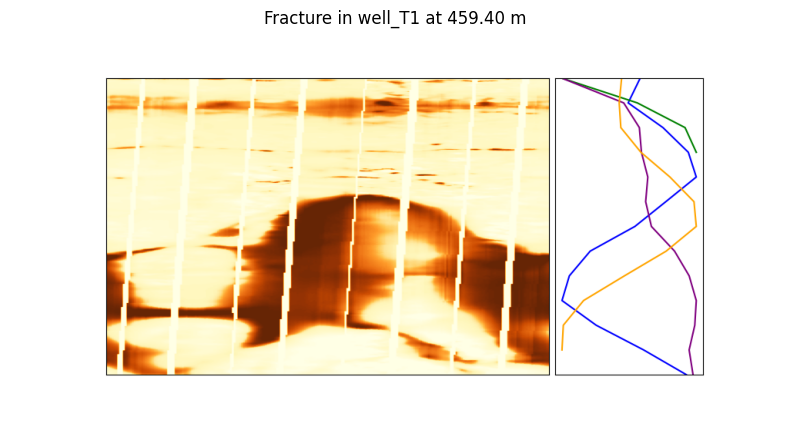

/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))


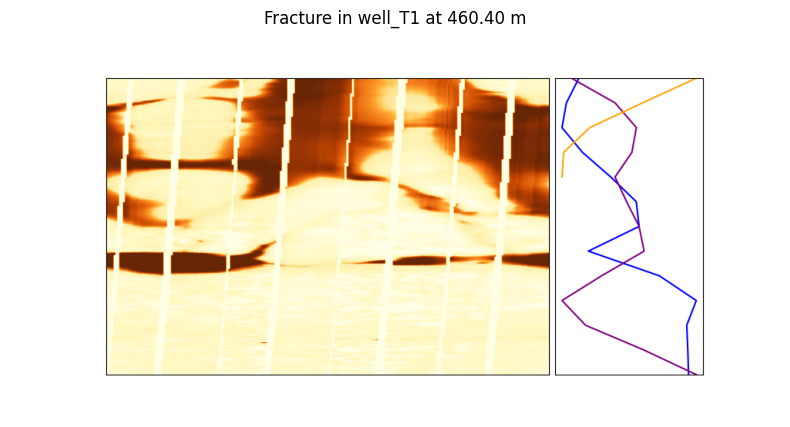

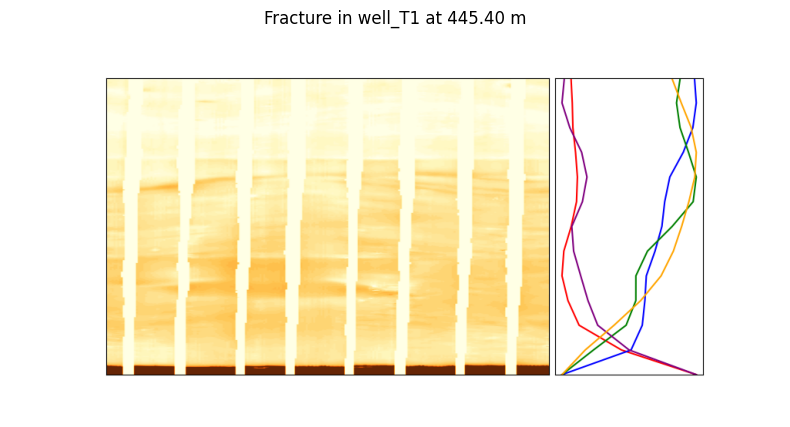

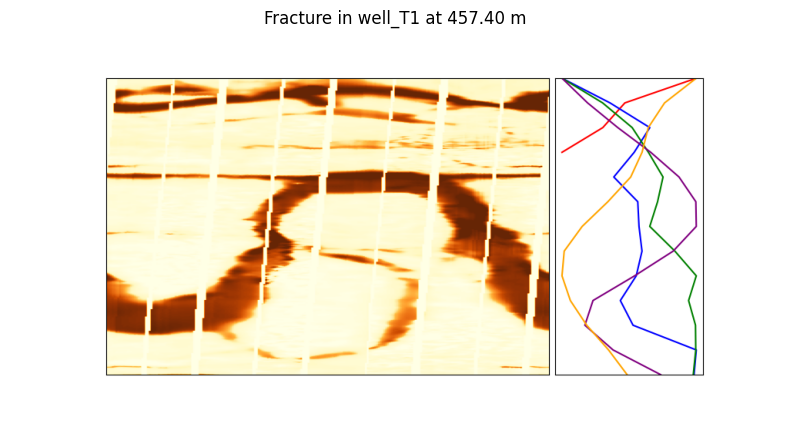

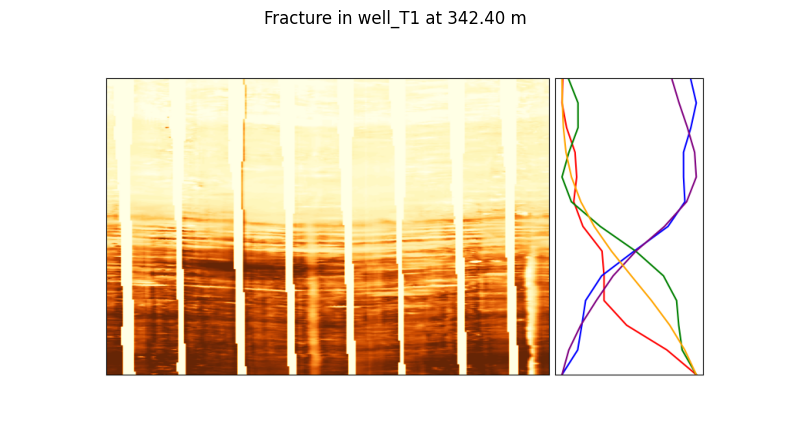

/tmp/ipykernel_1696/1011912353.py:52: RuntimeWarning: All-NaN slice encountered
  normalized_data = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))


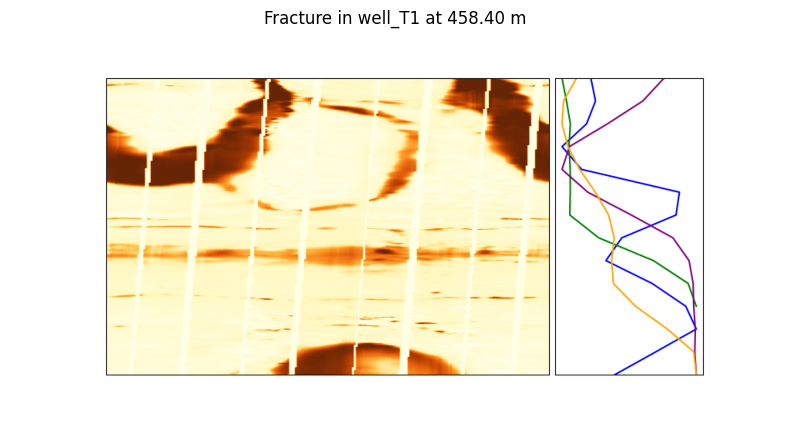

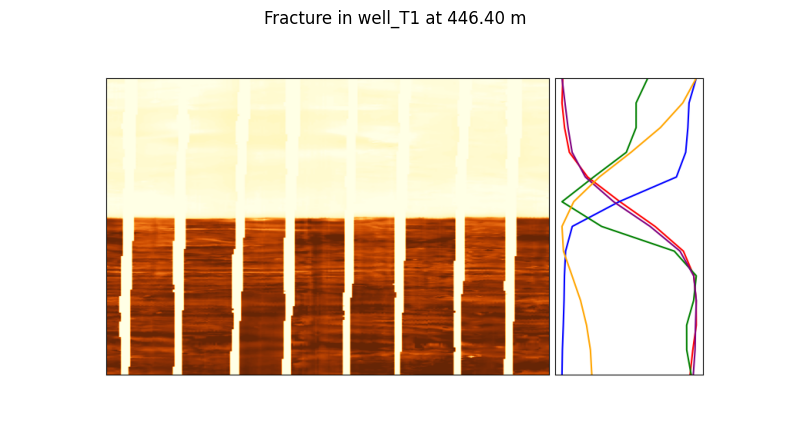

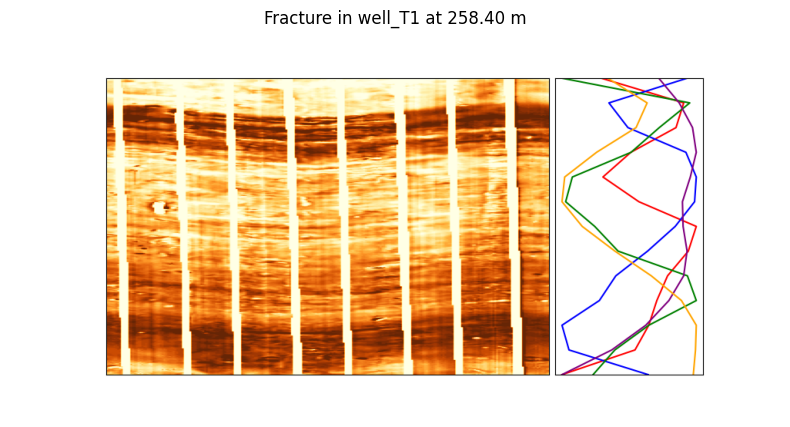

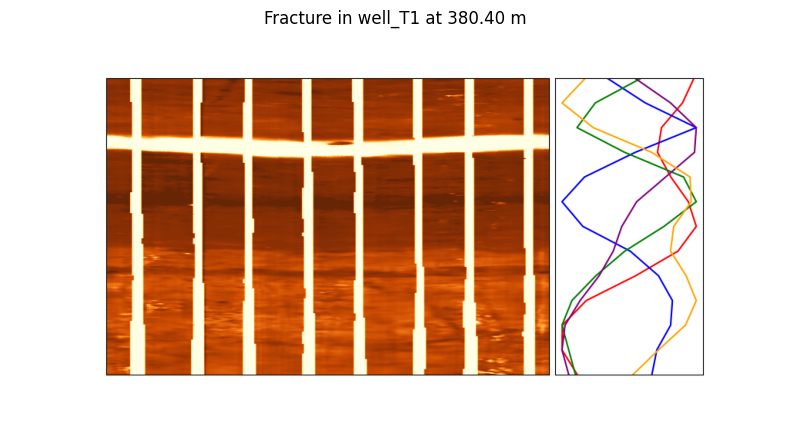

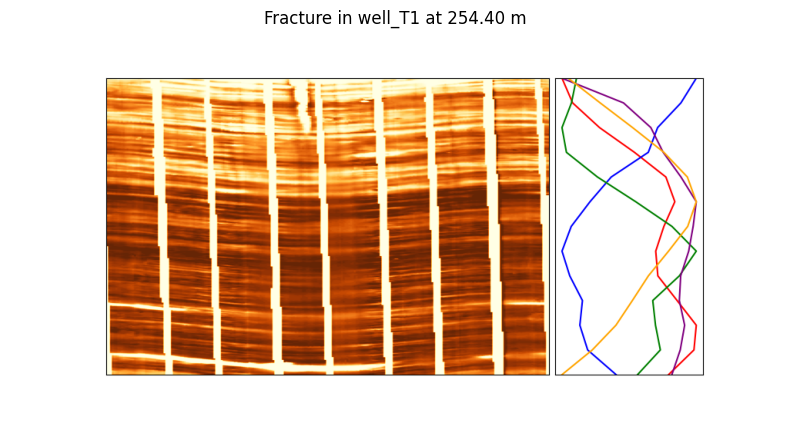

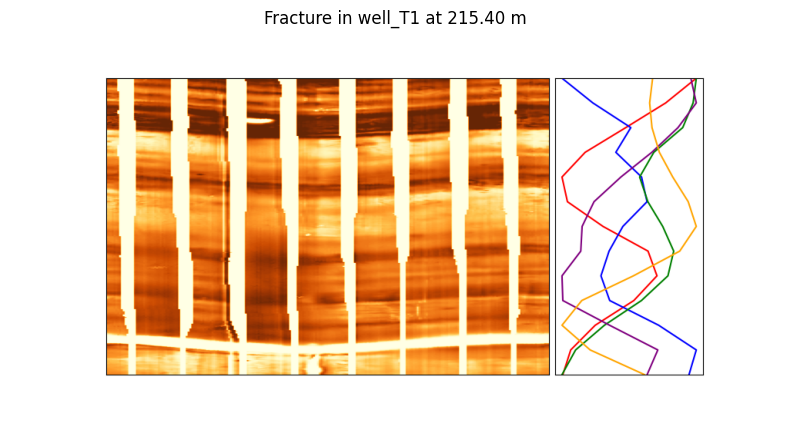

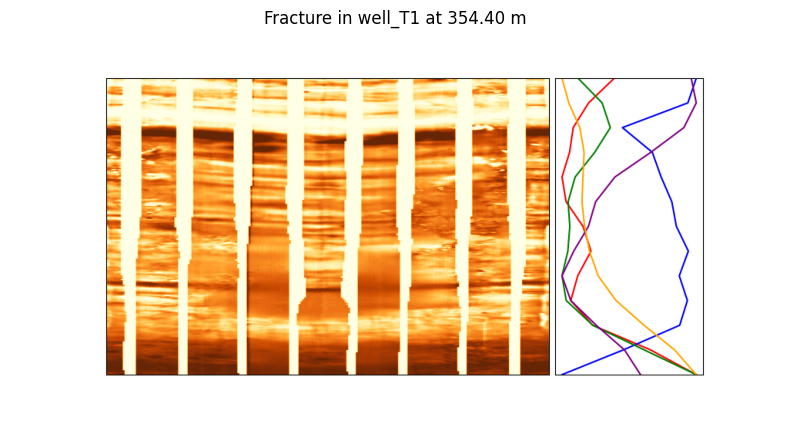

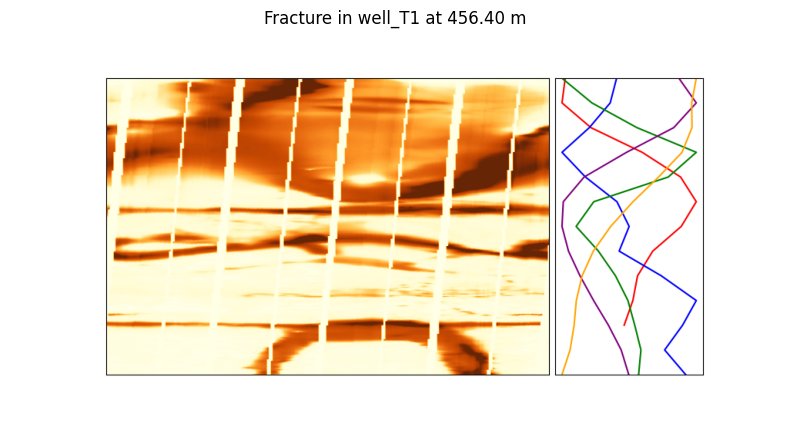

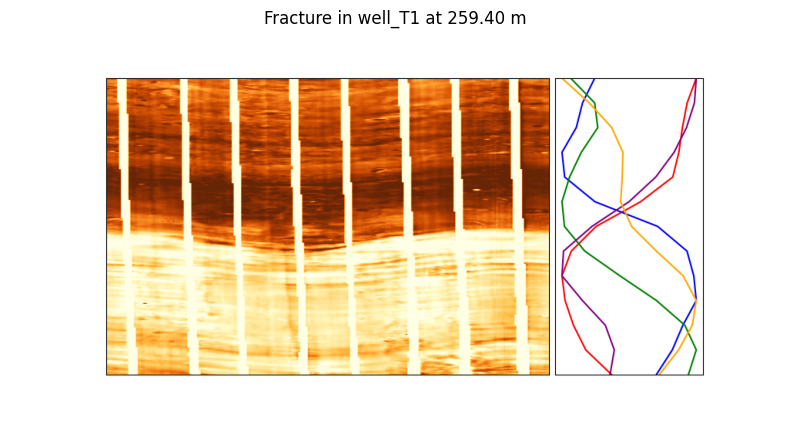

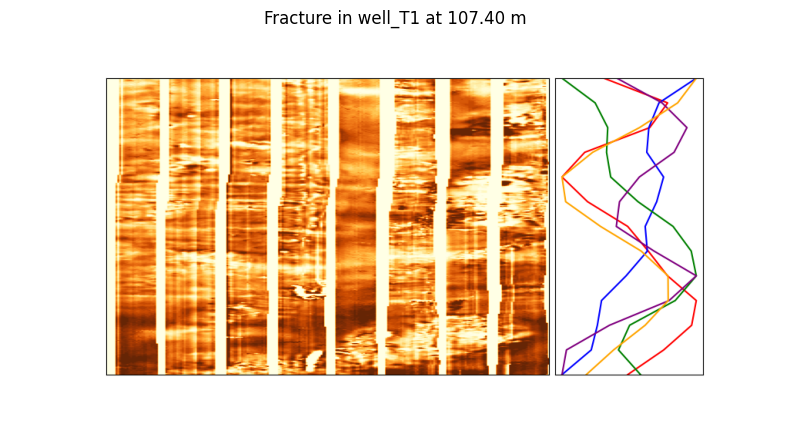

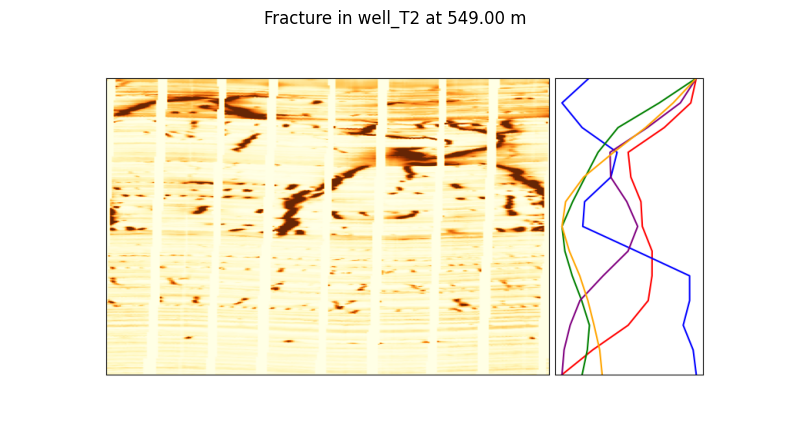

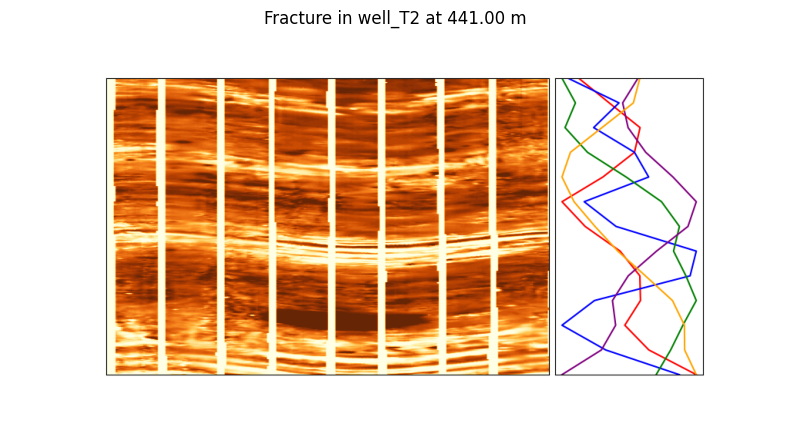

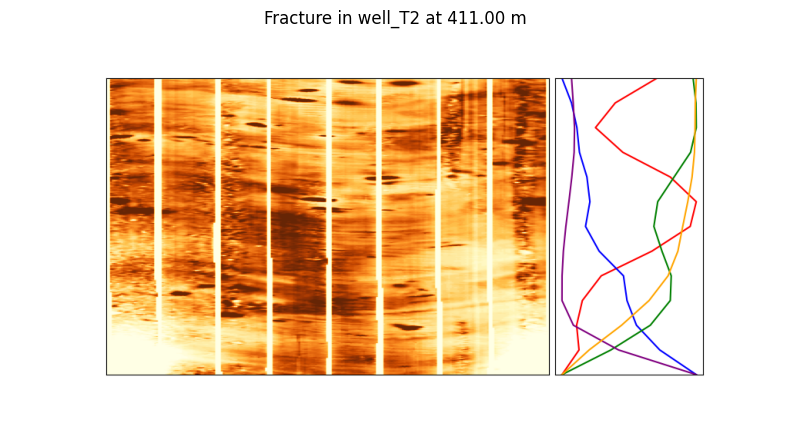

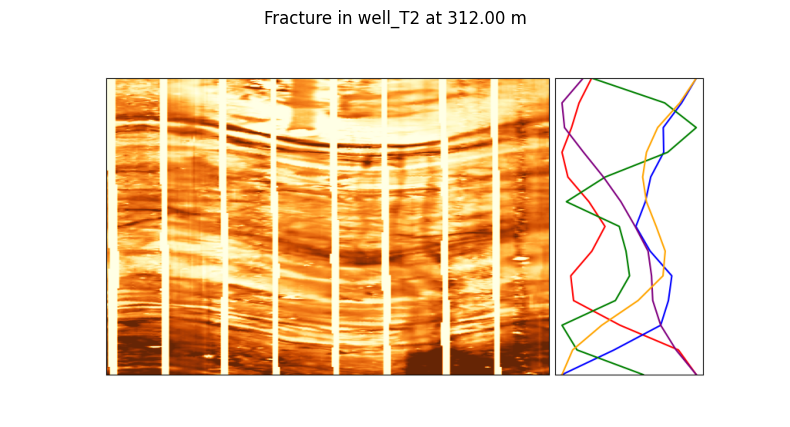

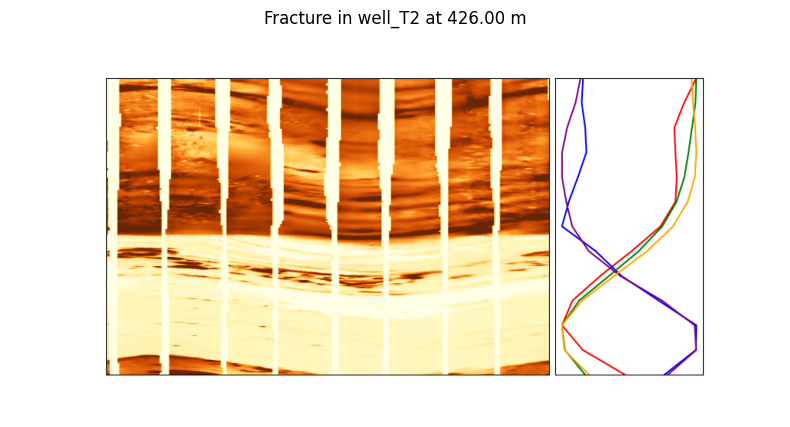

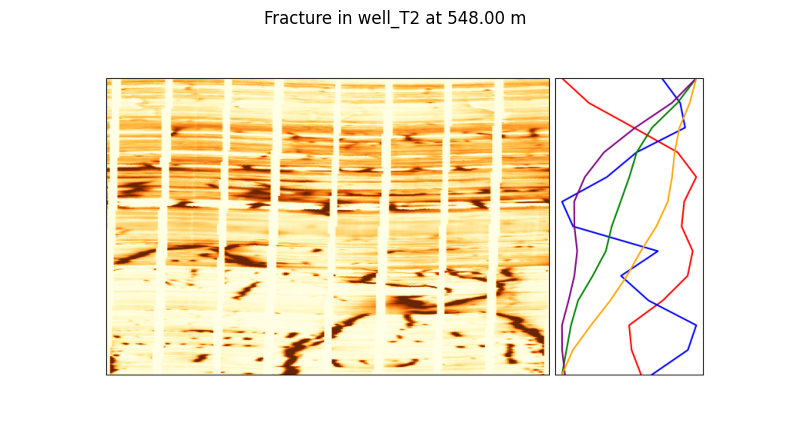

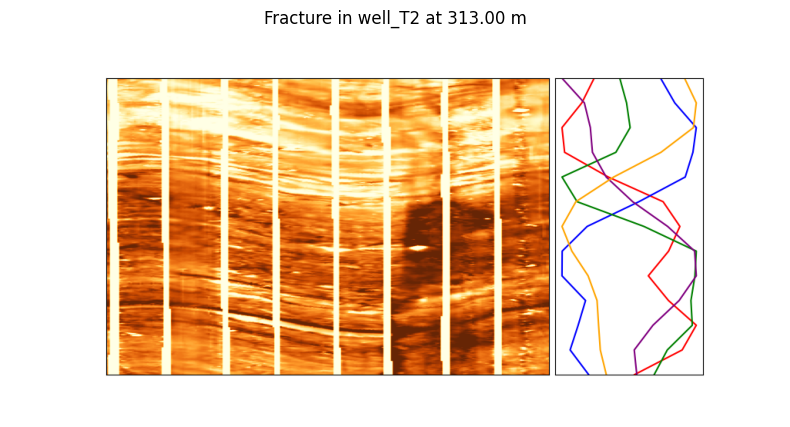

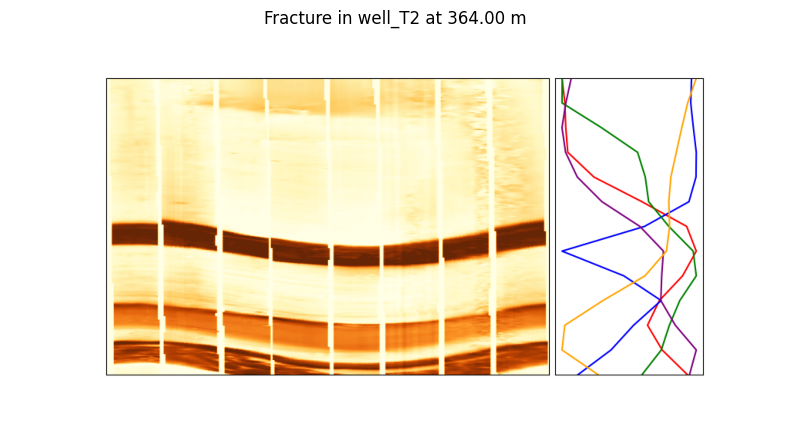

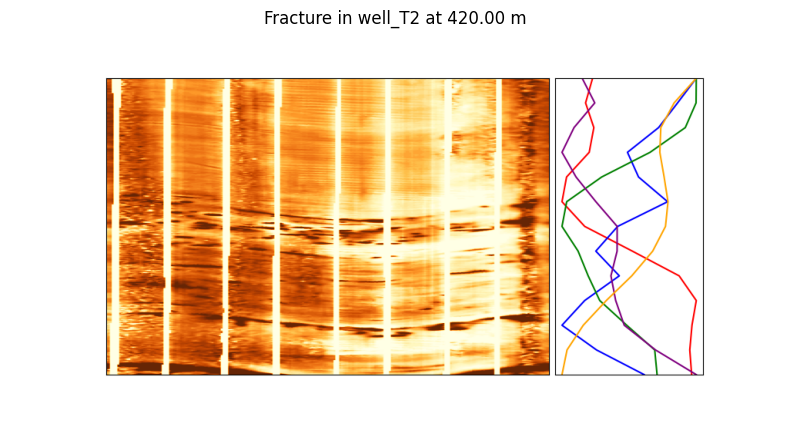

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_submission_fractures(submission_csv_path, well_images, well_logs):
    """
    Reads submission.csv and plots the multi-track fracture images for all the fractures
    detected in T1 and T2 wells.

    Parameters:
        submission_csv_path (str): Path to the CSV file with fracture detections.
        well_images (dict): Dictionary containing well image DataFrames (e.g., keys 'well_T1', 'well_T2').
        well_logs (dict): Dictionary containing well log DataFrames corresponding to each well.
    """
    # Read the submission file
    submission_df = pd.read_csv(submission_csv_path)

    # Loop through each detected fracture
    for idx, row in submission_df.iterrows():
        well = row['Well']
        depth = row['Depth']
        well_name = f"well_{well}"

        # Define a 1-meter window around the detected fracture depth
        top_depth = depth - 1.0
        bottom_depth = depth + 1.0

        # Extract the corresponding image data from the well_images DataFrame
        image_df = well_images[well_name]
        # Find the index positions closest to the top and bottom depths
        idx_top = (np.abs(image_df.index - top_depth)).argmin()
        idx_bottom = (np.abs(image_df.index - bottom_depth)).argmin()
        image_data = image_df.iloc[idx_top:idx_bottom]

        # Convert the static image to a dynamic image for enhanced contrast
        image_data_dynamic = static2dynamic(image_data)

        # Extract the corresponding well log data from the well_logs DataFrame
        logs_data = well_logs[well_name]
        log_idx_top = (np.abs(logs_data.index - top_depth)).argmin()
        log_idx_bottom = (np.abs(logs_data.index - bottom_depth)).argmin()
        logs_subset = {
            'GR': logs_data['GR'].iloc[log_idx_top:log_idx_bottom].values,
            'ILD': np.log10(logs_data['ILD'].iloc[log_idx_top:log_idx_bottom].values),
            'NPOR': logs_data['NPOR_LIM'].iloc[log_idx_top:log_idx_bottom].values,
            'RHOB': logs_data['RHO'].iloc[log_idx_top:log_idx_bottom].values,
            'DTC': logs_data['DT'].iloc[log_idx_top:log_idx_bottom].values
        }

        # Generate the multi-track image using your provided function
        multi_track_img = create_multi_track_image(
            image_data_dynamic, logs_subset, (top_depth, bottom_depth),
            ['GR', 'ILD', 'NPOR', 'RHOB', 'DTC']
        )

        # Plot the multi-track image
        plt.figure(figsize=(10, 5))
        plt.imshow(multi_track_img)
        plt.title(f"Fracture in {well_name} at {depth:.2f} m")
        plt.axis('off')
        plt.show()
    plt.savefig(f"{MAIN_PATH}/submision80.png")

# Example call to the function (ensure that "submission.csv" is in your working directory)
plot_submission_fractures("/teamspace/studios/this_studio/Machine-Learning-Competition-2024/fracture_identification/submissions/submission.csv", well_images, well_logs)
